# 🤖 Multimodal RAG with Embeddings of Text, Image, and Table Summaries
#### A cookbook for deriving more value from multi-modal data in Enterprise RAG Applications

### 🗂️ Introduction

Why Most Enterprise RAG Applications Fall Short: The Overlooked Importance of Context Engineering ?

Retrieval-Augmented Generation (RAG) applications are rapidly gaining traction across enterprises, offering powerful capabilities for knowledge retrieval and generative insights. However, the true effectiveness of these solutions hinges on a critical but often underestimated component—**data extraction and context engineering**. This notebook deals with 3 most-common problems seen in Enterprise RAG Applications.

1. **Multi-Modal data extraction**: Many RAG implementations fail to deliver tangible value because they rely solely on extracting plain text from source documents. This narrow approach overlooks the rich, structured, and visual data often embedded in enterprise content—such as **images, charts, and tables**. For instance, financial reports and research papers frequently convey essential information through non-textual formats that are crucial for accurate understanding and meaningful generation. Neglecting this rich content leads to incomplete context, ultimately resulting in **subpar performance and poor-quality outputs**. To build truly effective RAG solutions, enterprises must adopt a more comprehensive content extraction strategy—one that intelligently incorporates all relevant modalities, not just text.
2. **Text only inputs to LLM in Generation Phase** : Another common pitfall in enterprise RAG applications is the exclusive reliance on text when interacting with large language models (LLMs). When only textual data is passed to the model, valuable information embedded in images, tables, and other visual elements—which are often used to clarify, quantify, or summarize insights—is lost. This significantly weakens the model’s ability to generate accurate, complete responses.
3. **Cohesive Search Documents**: Equally important is the cohesion of extracted content. In most documents, information is presented in a tightly interlinked manner—text, visuals, and structured data are intentionally designed to work together to convey meaning. Extracting and using only fragments of that information disrupts this contextual integrity. For example, referencing a table without its corresponding explanatory text—or vice versa—can lead to misleading or incomplete answers. To achieve high-quality, reliable outputs, RAG applications must preserve this semantic cohesion during retrieval and context construction. This involves not only multimodal extraction but also thoughtful chunking, ranking, and packaging of information before it’s passed to the LLM.In essence, effective RAG isn’t just about finding relevant documents—it’s about preserving the full fidelity and structure of information within them. Overlooking this principle is a key reason why many enterprise RAG deployments underperform.


This notebook demonstrates how to leverage Azure AI services to build a robust multimodal RAG pipeline, enabling efficient data extraction, summarization, and **multi-vector** fields for downstream tasks.
The following section defines key learning objectives in each section. 

### 🎯 Key learning Objectives

1. 📄 **Data Extraction**: In this notebook we will learn to extract all types of data from rich PDFs using Azure Document Intelligence. 
2. 📝 **Summarization**: Implement text, table, and image summarization using Azure OpenAI models. At this stage we will also organize the data into a data-structure that supports **multi-vector** indexes.
3. 🧠 **Embedding & Search**: Create vector embeddings for multimodal data (text, images) and store them in Azure AI Search for efficient retrieval. Reshape search results to optimize context for text generation using both text and image data. Finally, demonstrate how relevant retrieved images enhance the generated response.

### 🏁 Conclusion

By the end of this notebook, users will have a clear understanding of how to build a multimodal RAG pipeline that integrates text, image, and table data for advanced AI applications. This approach enhances the ability to generate meaningful insights from diverse data sources, paving the way for innovative solutions in enterprise and research domains. In short, robust context engineering is not optional—it’s foundational. Without it, even the most advanced RAG systems are at risk of missing the mark.🚀

### Environment setup

This cell outlines the installation of required Python packages and the configuration of environment variables necessary for running the notebook Multimodal RAG with embeddings of Text, Image, and Table Summaries.

---

#### **Installation**
The following Python packages are installed to enable multimodal retrieval-augmented generation (RAG) capabilities:
```python
%pip install --quiet azure-ai-documentintelligence "python-dotenv" "langchain-openai" "azure-search-documents"
```

---

#### **Environment Variables**
The `.env` file must include the following configurations for secure credential management:

| **Variable Name**                  | **Description**                                                                 |
|------------------------------------|---------------------------------------------------------------------------------|
| `AZURE_OPENAI_ENDPOINT`            | Azure OpenAI endpoint URL                                                      |
| `AZURE_OPENAI_API_KEY`             | API key for Azure OpenAI                                                       |
| `AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT` | Endpoint for Azure Document Intelligence                                       |
| `AZURE_DOCUMENT_INTELLIGENCE_KEY`  | API key for Azure Document Intelligence                                        |
| `AZURE_VISION_MODEL_ENDPOINT`      | Endpoint for Azure Vision Model                                                |
| `AZURE_VISION_MODEL_KEY`           | API key for Azure Vision Model                                                 |
| `AZURE_AI_SEARCH_SERVICE_NAME`     | Name of the Azure AI Search service                                            |
| `AZURE_AI_SEARCH_API_KEY`          | API key for Azure AI Search service                                            |
| `AOAI_EMBEDDINGS_DEPLOYMENT_NAME`  | Deployment name for Azure OpenAI embeddings                                    |
| `AZURE_AI_SEARCH_INDEX_NAME`       | Name of the Azure AI Search index                                              |

---

#### **Key Notes**
- Ensure the `.env` file is properly configured before running the notebook.
- The packages installed enable document analysis, image processing, vector embeddings, and search capabilities using Azure AI services.

This setup is critical for enabling multimodal RAG workflows that integrate text, image, and table embeddings for advanced AI applications.

In [38]:
import os
from dotenv import load_dotenv
from azure.core.credentials import AzureKeyCredential
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.ai.documentintelligence.models import AnalyzeOutputOption
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from langchain_openai import AzureChatOpenAI
from langchain_openai.embeddings import AzureOpenAIEmbeddings
import uuid
from IPython.display import Markdown

# Load environment variables from .env file for secure credential management
load_dotenv()

# Retrieve Azure and OpenAI configuration from environment variables
di_endpoint = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT")
di_credential = AzureKeyCredential(os.getenv("AZURE_DOCUMENT_INTELLIGENCE_KEY"))
chat_model = os.getenv("AOAI_CHAT_DEPLOYMENT_NAME", "gpt-4o")
aoai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
aoai_key = os.getenv("AZURE_OPENAI_API_KEY")
vision_model_endpoint = os.getenv("AZURE_VISION_MODEL_ENDPOINT")
vision_model_key = os.getenv("AZURE_VISION_MODEL_KEY")
search_endpoint = os.getenv("AZURE_AI_SEARCH_SERVICE_NAME")
search_key = os.getenv("AZURE_AI_SEARCH_API_KEY")
embeddings_model = os.getenv("AOAI_EMBEDDINGS_DEPLOYMENT_NAME", "text-embedding-3-small")
search_index_name = os.getenv("AZURE_AI_SEARCH_INDEX_NAME", "langchain-vector-demo")

# Initialize Azure Document Intelligence client for document analysis
document_intelligence_client = DocumentIntelligenceClient(di_endpoint, di_credential)

# Initialize Azure Vision client for image analysis
client = ImageAnalysisClient(
    endpoint=vision_model_endpoint,
    credential=AzureKeyCredential(vision_model_key)
)

# Initialize Azure OpenAI chat client for LLM-based summarization
llm_client = AzureChatOpenAI(
    azure_deployment=chat_model,
    api_version="2023-05-15",
    temperature=0.3,
    model_name=chat_model,
    azure_endpoint=aoai_endpoint,
    api_key=aoai_key,
)

# Initialize Azure OpenAI embeddings client for vectorization
embeddings_model_client = AzureOpenAIEmbeddings(
    azure_endpoint=aoai_endpoint,
    api_key=aoai_key,
    azure_deployment=embeddings_model,
)

# Path to the sample document (PDF) to be analyzed
# For simplicity, this example uses a document sampled from Azure Architecture reference
# File can be downloaded from here https://drive.google.com/file/d/1oWxuqCAnu5GEOgNA0pHQCeLgxPf-wduU/view?usp=sharing
path_to_sample_documents = "azure_ref_architecture.pdf"

# Analyze the document using the prebuilt-layout model, requesting figure extraction
with open(path_to_sample_documents, "rb") as f:
    poller = document_intelligence_client.begin_analyze_document(
        "prebuilt-layout",
        body=f,
        output=[AnalyzeOutputOption.FIGURES], # Requesting figure extraction
    )
result = poller.result()

### Data Extraction

In this section we will extract the data and organize as Page -> Page Count [tables, images], this helps in efficient search retrieval. Imagine of search query matches the table, image summary the entire page can be located. 

In [39]:
# Extract Text and Headings
pages = []

# Structure the documents as Pages -> Paragraphs -> Text
for paragraph in result.paragraphs:
    page = {}
    page_number = paragraph["boundingRegions"][0]["pageNumber"] if paragraph["boundingRegions"] else None
    role = paragraph["role"] if "role" in paragraph else "paragraph"
    content = paragraph["content"] if "content" in paragraph else ""
    
    # check if page already exists
    if page_number and any(p["page_number"] == page_number for p in pages):
        page = next(p for p in pages if p["page_number"] == page_number)
        page["content"] = page.get("content", "") + " " + content
        if role in ["heading", "sectionHeading", "title"]:
            page["sections"] = page.get("sections", "") + "," + content
        continue
    else:
        page = {
            "id": str(uuid.uuid4()),
            "content": content,
            "sections": content if role in ["heading", "sectionHeading", "title"] else "",
            "page_number": page_number,
            "page_content": [] # Initialize to fill tables, figures later
        }
    pages.append(page)
print(f"Extracted {len(pages)} documents with headings and text.")

# Extract Tables and add to pages
table_elements = []
if result.tables:
    for idx, table in enumerate(result.tables):
        page_number = table["boundingRegions"][0]["pageNumber"] if table["boundingRegions"] else None
        page = next((p for p in pages if p["page_number"] == page_number), None)
        if not page:
            print(f"Page {page_number} not found for table {idx}. Skipping.")
            continue
        print(f"Table {idx} found on page {page_number}.")
        t_documents = []
        for cell in table.cells:
            t_document = {}
            t_document["row"] = cell.row_index
            t_document["column"] = cell.column_index
            t_document["row_content"] = cell.content
            t_documents.append(t_document)
        page["page_content"].append({
            "type": "table",
            "content": str(t_documents),
            "page_number": page_number,
            "id": str(uuid.uuid4())
        })
    print(f"Extracted {len(result.tables)} tables from the document.")    
	
# # Extract Figures and add to pages later
if result.figures:
    operation_id = poller.details["operation_id"]
    os.makedirs("extracted_images", exist_ok=True)
    for figure in result.figures:
        page_number = figure["boundingRegions"][0]["pageNumber"] if figure["boundingRegions"] else None
        page = next((p for p in pages if p["page_number"] == page_number), None)
        if not page:
            print(f"Page {page_number} not found for figure {figure.id}. Skipping.")
            continue
        if figure.id:
            response = document_intelligence_client.get_analyze_result_figure(
                model_id=result.model_id, result_id=operation_id, figure_id=figure.id
            )
            print(f"Figure {figure.id} extracted from page {page_number}.")
            page['page_content'].append({
                "type": "figure",
                "content": "", # this will be filled with the image summary later
                "image_url": f"extracted_images/{figure.id}.png", # Save the public URL for the image in real world scenarios
                "page_number": page_number,
                "id": figure.id
            })
            with open(f"extracted_images/{figure.id}.png", "wb") as writer:
                writer.writelines(response)
else:
    print("No figures found.")
print(f"Extracted {len(result.figures)} figures from the document.")

Extracted 31 documents with headings and text.
Table 0 found on page 6.
Table 1 found on page 28.
Table 2 found on page 29.
Extracted 3 tables from the document.
Figure 2.1 extracted from page 2.
Figure 12.1 extracted from page 12.
Figure 26.1 extracted from page 26.
Figure 27.1 extracted from page 27.
Extracted 4 figures from the document.


In [40]:
print("Sample Content with Tables")
print(pages[5])
print('--'*50)
print("Sample Content with Figures")
print(pages[1])

Sample Content with Tables
{'id': 'fe6db65d-574d-4fb7-8682-83e3f00f50fa', 'content': "Identity and access management The following guidance expands on the identity and access management guidance in the App Service baseline architecture. The chat UI uses its managed identity to authenticate the chat UI API code to Foundry Agent Service by using the Azure AI Persistent Agents SDK. The Azure AI Foundry project also has a managed identity. This identity authenticates to services such as AI Search through connection definitions. The project makes those connections available to Foundry Agent Service. An Azure AI Foundry account can contain multiple Azure AI Foundry projects. Each project should use its own system-assigned managed identity. If different workload components require isolated access to connected data sources, create separate Azure AI Foundry projects within the same account and avoid sharing connections across them. If your workload doesn't require isolation, use a single projec

### Summarization

In this section we generate summaries for tables, images. I'm using GPT4o for image summarization you may use any VLM. Generating summaries for pages is optionally here, however it may help increase search score when hybrid search is used. 

**Note**: I initially planned to use Azure Computer Vision, however I noticed that the it only provides precise captions of the image but does not generate summaries hence I switched to VLM (infact a multi-modal LLM)

In [41]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
import base64
import tqdm

# Text Summarization 
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)
summarize_chain = {"element": lambda x: x} | prompt | llm_client | StrOutputParser()

# Image Summarization
def encode_image(image_path):
    '''Getting the base64 string'''
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def image_summarize(image_path):
    """Make image summary"""
    prompt_text = "You are an assistant tasked with summarizing images. Extract text, image from the input and Give a concise summary."
    img_base64 = encode_image(image_path)
    msg = llm_client.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt_text},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{img_base64}" # Use base64 encoded image
                        },
                    },
                ]
            )
        ]
    )
    return msg.content

# Summarize content of pages
# Note: The content vectorization is commented out to avoid increase in size of the file
texts = [i["content"] for i in pages if i["content"] != ""]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
for i, page in tqdm.tqdm(enumerate(pages)):
    page["summary"] = text_summaries[i] if i < len(text_summaries) else "No summary available" 
    # page["content_vector"] = embeddings_model_client.embed_documents(page["content"])
    for content in page["page_content"]:
        if content["type"] == "table":
            content["summary"] = summarize_chain.invoke(content["content"])
            # content["content_vector"] = embeddings_model_client.embed_documents(content["summary"] + str(content["text"])) # we remove the content vector for tables if it is too large
        elif content["type"] == "figure":
            content["summary"] = image_summarize(content['image_url'])
            # content["content_vector"] = embeddings_model_client.embed_documents(content["summary"])
        else:
            content["summary"] = "No summary available"

31it [00:29,  1.05it/s]


### Multi-Vector Search

**Azure Multi-Vector Field Search [Public Preview]**

This notebook uses a public preview feature in Azure AI Search called [Multi-vector field](https://learn.microsoft.com/en-us/azure/search/vector-search-multi-vector-fields). It allows indexing multiple child vectors within a single document field, making it particularly effective for multimodal data or long-form documents, where a single vector representation may lose important context or detail. We can embed multiple chunks of a document and associate those embeddings with the parent document, allowing retriever hits on the chunks to return the larger document. This capability ensures finer-grained retrieval and relevance when working with diverse data types like text and images.

Since this feature is in preview the only support method to create the Index is via Portal or REST API. Before you proceed make sure the index is created in Azure Search either from the portal or via REST API. 
The Index `JSON` file can be found under `/configs/multi-vector-index.json`

In [46]:
from azure.search.documents import SearchClient

search_client = SearchClient(
    endpoint=search_endpoint,
    index_name=search_index_name,
    credential=AzureKeyCredential(search_key)
)

# Uploading the documents to Azure AI Search
# Note: Assuming the index with same name above is created in Azure Search either from the portal or via REST API.
# The Index `JSON` file can be found under `/configs/multi-vector-index.json`
search_client.upload_documents(
    documents=pages
)

In [47]:
# Lets do a search to find the page with the query
result = search_client.search("show integration of Azure Web Application Firewall (WAF)", top=1)
for r in result:
    print(f"Page Number: {r['page_number']}, Page Summary: {r['summary']}")
    for content in r["page_content"]:
        print('-' * 50)
        display(Markdown(f"Page Content Summary: {content['summary']}"))

Page Number: 12, Page Summary: This architecture leverages the Foundry Agent Service standard setup to ensure enterprise-grade security, compliance, and control for chat applications on Azure. Key features include:

- **Network Isolation**: Users bring their own network and Azure resources to isolate data and store chat/agent state.
- **Private Endpoints**: All communication between components and Azure services occurs over private endpoints, keeping data traffic within the virtual network.
- **Outbound Traffic Control**: Outbound traffic is routed through Azure Firewall, enforcing strict egress rules.
- **Baseline Reference**: The Foundry Agent Service reference implementation provides a foundational end-to-end chat solution for customization and scaling toward production.

**Key Components**:
- Azure Application Gateway with Web Application Firewall (WAF) for request routing and inspection.
- Private endpoints for secure access to Azure services like Key Vault, Storage, AI Search, an

Page Content Summary: ### Summary of the Image:
The diagram illustrates the architecture of an Azure-based solution integrating multiple services for secure and efficient application deployment and AI model utilization. Key components include:

1. **User Interaction**: Users access the system via a virtual network with DNS zones, Application Gateway (with Azure WAF), and DDoS protection.
2. **Application Services**: Managed identity-enabled App Services are deployed across multiple zones, supported by private endpoints for secure connectivity to Azure Key Vault, Azure Storage, and other resources.
3. **Azure AI Foundry Integration**: The Foundry Agent Service connects to Azure AI Foundry accounts and projects using managed identities.
4. **Knowledge Store**: Private endpoints link to services like Azure Cosmos DB, Azure Storage, and Azure Cognitive Search for data management and retrieval.
5. **Security Layers**: Azure Firewall and jump box subnets handle outbound traffic and secure agent builds.
6. **Build Agents**: Dedicated subnets host build agents for deploying and managing AI models.
7. **Monitoring**: Application Insights and Azure Monitor provide system observability.

The architecture emphasizes security, scalability, and integration of AI capabilities with foundational Azure services.

 As you can see the search result returns the page number and summary of the page although the query matches the image summary. This allows for efficient retrieval of relevant information based on user queries. # This is particularly useful in scenarios where users need to quickly locate specific information within large documents, 

### RAG with multi-modal data

In this section, we will build a RAG (Retrieval-Augmented Generation) pipeline. During the retrieval phase, search results will be restructured to include page content, table data, image summaries, and the images themselves. Images will be converted to Base64-encoded values and passed to a multimodal language model to enhance the quality of the generated response. The most relevant image identified for the query will also be included in the final response to deliver a richer user experience.

In [48]:
from langchain_community.retrievers import AzureAISearchRetriever
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage

# Initialize user memory to store conversation context
conversation_memory = {}

retriever = AzureAISearchRetriever(
    top_k=3, 
    service_name=search_endpoint,
    api_key=search_key,
    content_key="content",  # This is the field name for the vector embeddings
    index_name=search_index_name,
    azure_ad_token="True" # Bug in langchain-azure-ai-search, need to set this to True to use API Key
)

def splitDocs(docs, config):
    imgs = []
    table_summaries = []
    image_summaries = []
    image_urls = []
    conversation_id = config['metadata']['conversation_id']
    for doc in docs:
        content = doc.page_content + "\n" + "\n".join([p["summary"] for p in doc.metadata["page_content"]])
        for page_content in doc.metadata["page_content"]:
            if page_content["type"] == "table":
                table_summaries.append(page_content["summary"])
            elif page_content["type"] == "figure":
                image_summaries.append(page_content["summary"])
                image_urls.append(page_content["image_url"])
                base64_image = encode_image(page_content["image_url"])
                imgs.append(base64_image)
    conversation_memory[conversation_id] = {'image_urls': image_urls}
    return { 
        'content': content, 
        'images': imgs, 
        'table_summaries': table_summaries, 
        'image_summary': image_summaries, 
        "image_urls": image_urls 
    }

def prompt_func(dict):
    format_texts = "\n".join(dict['context']["content"])
    table_summaries = "\n".join(dict['context']["table_summaries"])
    image_summaries = "\n".join(dict['context']["image_summary"])
    message = [
        SystemMessage(
            content="You are a helpful assistant! Your name is Bob. \
                You are given context that contains document content along with tables and images. A summary of the content along with tables and images is provided. \
                You are an expert in answering questions using text, tables, and images."
        ),
        HumanMessage(
            content=[
                {"type": "text", 
                 "text": f"""
                 Answer the question based only on the following context, which can include text, tables, and the below image: Question: {dict["question"]} \
                    Text {format_texts}, table summaries: {table_summaries}, image summaries: {image_summaries} """},
            ]
        )
    ]
    if dict['context']['images']:
        for i in range(len(dict['context']['images'])):
            message.append(
                HumanMessage(
                    content=[
                        {"type": "image_url", 
                         "image_url": {"url": f"data:image/jpeg;base64,{dict['context']['images'][i]}"}}
                    ]
                )
            )
    else:
        print("No images found in the context.")
    return message

conversation_id = str(uuid.uuid4())
chain = (
    {"context": retriever | RunnableLambda(splitDocs), "question": RunnablePassthrough()} 
    | RunnableLambda(prompt_func) 
    | llm_client 
    | StrOutputParser()
)
answer = chain.invoke(
    {"question": "As an AI Architect summarize the Azure AI Foundry chat reference architecture"}, 
    config={"conversation_id": conversation_id}
)

In [49]:
display(Markdown(answer))
######## Display images 
for image_url in conversation_memory[conversation_id]['image_urls']:
    display(Markdown(f"![Image]({image_url})"))

The Azure AI Foundry chat reference architecture is designed to enable secure, scalable, and efficient integration of AI capabilities with foundational Azure services. It incorporates enterprise-grade security, compliance, and control, leveraging private endpoints and Azure Firewall for network isolation and secure communication. Key components include:

1. **User Interaction**: Users interact with the system through a virtual network, DNS zones, and an Application Gateway with Azure Web Application Firewall (WAF) for request inspection. DDoS protection ensures resilience against attacks.

2. **Application Services**: Managed identity-enabled App Services are deployed across multiple zones, connected securely to Azure resources like Key Vault, Storage, and others via private endpoints.

3. **Azure AI Foundry Integration**: The Foundry Agent Service connects to Azure AI Foundry accounts and projects, utilizing managed identities for secure access.

4. **Knowledge Store**: Private endpoints link to services like Azure Cosmos DB, Azure Storage, and Azure Cognitive Search for data storage, management, and retrieval.

5. **Security Layers**: Azure Firewall enforces egress rules for outbound traffic, while jump box subnets provide secure access for managing agent builds.

6. **Build Agents**: Dedicated subnets host build agents responsible for deploying and managing AI models.

7. **Monitoring**: Application Insights and Azure Monitor provide observability into system performance and health.

The architecture ensures that all communication between components and Azure services occurs over private endpoints, maintaining data traffic within the workload's virtual network. Outbound traffic is strictly routed through Azure Firewall, enforcing security policies. This setup serves as a baseline for developing custom solutions and transitioning to production environments.

![Image](extracted_images/12.1.png)

### Sample Response as Image

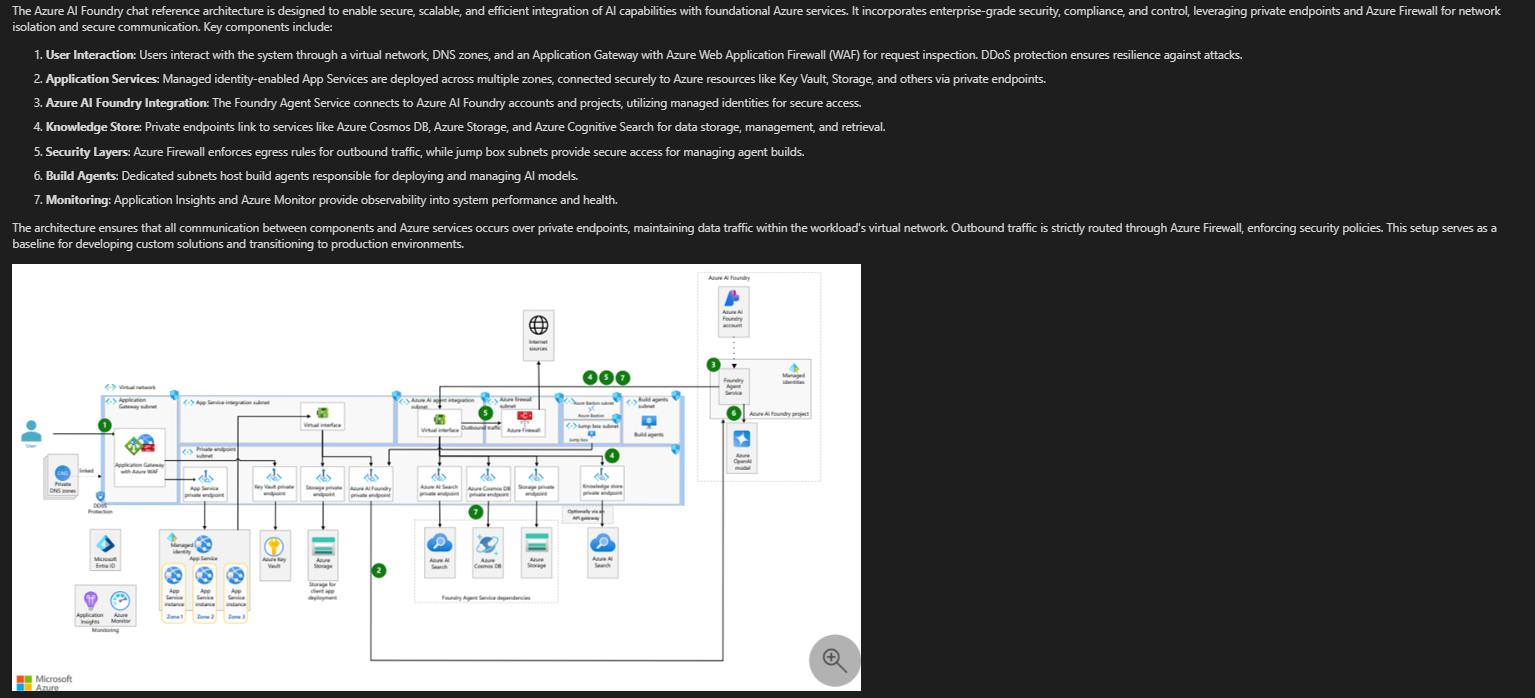